In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import clip
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline

from transform import _transform

数据格式

In [2]:
anno_train = json.load(open('FS2K/anno_train.json', 'r'))
anno_train[0]

{'image_name': 'photo1/image0110',
 'skin_color': [163, 139],
 'lip_color': [156.97750511247443, 82.51124744376278, 79.0],
 'eye_color': [118.65178571428571, 72.25892857142857, 69.59821428571429],
 'hair': 0,
 'hair_color': 2,
 'gender': 0,
 'earring': 1,
 'smile': 1,
 'frontal_face': 1,
 'style': 0}

数据预处理

In [20]:
N_CLASSES = {'hair': 2, 'hair_color': 5, 'gender': 2, 'earring': 2, \
    'smile': 2, 'frontal_face': 2, 'style': 3}
# N_CLASSES = {'gender': 2}

In [21]:
class Data(Dataset):
    def __init__(self, anno_file, split='train'):
        super().__init__()
        self.anno = json.load(open(anno_file, 'r'))
        self.len = len(self.anno)
        self.split = split
        self.transform = _transform((448, 448))

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        img_name = self.anno[index]['image_name']
        img_name = img_name.replace('/', '_')
        img_name = img_name.replace('photo', 'sketch')
        img_name = img_name.replace('image', 'sketch')
        img_path = f'FS2K/{self.split}/sketch/' + img_name + '.png'
        img = Image.open(img_path)
        img = self.transform(img)
        label = {key: self.anno[index][key] for key in N_CLASSES}
        return img, label

In [22]:
BATCH_SIZE = 8
train_set = Data('FS2K/anno_train.json')
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)
val_set = Data('FS2K/anno_test.json', split='test')
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=False, pin_memory=True)


In [5]:
img_, label_ = train_set[0]
img_.shape

torch.Size([3, 448, 448])

搭模型

In [23]:
class FrozenBatchNorm(nn.Module):
    def __init__(self, alive_bn):
        super().__init__()
        self.eps = 1e-5
        self.weight = alive_bn.weight
        self.bias = alive_bn.bias
        self.register_buffer('running_mean', alive_bn.running_mean)
        self.register_buffer('running_var', alive_bn.running_var)
        del alive_bn
    
    def forward(self, x):
        return F.batch_norm(
            x,
            self.running_mean,
            self.running_var,
            self.weight,
            self.bias,
            training=False,
            eps=self.eps
        )

def bn_convert(model, learned=False):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            _module = FrozenBatchNorm(module)
            _module.weight.requires_grad = learned
            _module.bias.requires_grad = learned
            model.__setattr__(name, _module)
            del module
        else:
            bn_convert(module, learned)


In [24]:
clip_model, _ = clip.load('/data-ssd/shaozw/RN50x64.pt', device='cpu')
class Sk2Attr(nn.Module):
    def __init__(self):
        super().__init__()
        cnn = deepcopy(clip_model.visual)

        ############ CNN Modifing ############
        cnn.float()
        attnpool = cnn.attnpool
        cnn.attnpool = nn.Identity()
        bn_convert(cnn.bn1)
        bn_convert(cnn.bn2)
        bn_convert(cnn.bn3)
        bn_convert(cnn.layer1)
        bn_convert(cnn.layer2)
        bn_convert(cnn.layer3)
        bn_convert(cnn.layer4)
        for p in cnn.parameters():
            p.requires_grad = False
        # for p in cnn.layer3.parameters():
        #     p.requires_grad = True
        # for p in cnn.layer4.parameters():
        #     p.requires_grad = True
        ############ CNN Modifing ############
        
        self.cnn = cnn
        self.classifiers = {
            key: nn.Sequential(deepcopy(attnpool), nn.Linear(1024, N_CLASSES[key])) \
            # key: nn.Sequential(deepcopy(attnpool)) \
                for key in N_CLASSES
        }
        self.classifiers_list = nn.ModuleList(list(self.classifiers.values()))
    
    def forward(self, x):
        x = self.cnn(x)
        # print(x.shape)
        return {key: self.classifiers[key](x) for key in N_CLASSES}


搭建训练逻辑

In [8]:
LR = 1e-3
EPOCHS = 6
WARMUP = 2 *len(train_loader)
MILESTONES = [4 * len(train_loader)]
def get_optim_utils(net, lr=LR, warmup=WARMUP, milestones=MILESTONES, decay_r=0.1, init_r=0.1):
    criterions = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=lr
    )
    schd1 = torch.optim.lr_scheduler.LinearLR(optimizer, init_r, total_iters=warmup) 
    schd2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=decay_r)
    # schd2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7, last_epoch=-1)
    schd = torch.optim.lr_scheduler.SequentialLR(optimizer, [schd1, schd2], milestones=[warmup])
    return criterions, optimizer, schd

In [ ]:
# plot the curve of lr
criterions, optimizer, schd = get_optim_utils(net, 1e-4, 130, [130], 0.2, 0.1)
lr_record = []
for i in range(400):
    schd.step()
    lr_record.append(optimizer.param_groups[0]['lr'])
# print(lr_record)
plt.plot(lr_record)
plt.xlabel('steps')
plt.ylabel('lr')


In [25]:
@torch.no_grad()
def validate(net, verbose=True):
    net.eval()
    correct = {key: 0 for key in N_CLASSES}
    n_sample = len(val_loader) * BATCH_SIZE
    for i, (img, label) in enumerate(val_loader):
        img = img.cuda()
        output = net(img)
        pred = {key: output[key].argmax(dim=1).cpu() for key in N_CLASSES}
        correct = {key: correct[key] + (pred[key] == label[key]).sum().item()\
             for key in N_CLASSES}
    acc_per_task = {key: correct[key] / n_sample for key in N_CLASSES}
    if verbose:
        print('Eval:', end='')
        for key in N_CLASSES:
            print('\t[{} {:.2f}]'.format(key, acc_per_task[key] * 100), end='\t')
        print()
    return acc_per_task

定义一些数据记录工具

In [26]:
training_total_loss = []
training_tasks_loss = {key: [] for key in N_CLASSES}
validation_tasks_acc = {key: [] for key in N_CLASSES}

In [27]:
def refresh_records():
    global training_total_loss, training_tasks_loss, validation_tasks_acc
    training_total_loss = []
    training_tasks_loss = {key: [] for key in N_CLASSES}
    validation_tasks_acc = {key: [] for key in N_CLASSES}

In [42]:
COLOR = {key: 'C{}'.format(i) for i, key in enumerate(N_CLASSES)}
def smooth(vlist):
    rlist = []
    for i in range(1, len(vlist)):
        j = max(0, i - 20)
        v = sum(vlist[j:i]) / max(1, i - j)
        rlist.append(v)
    return rlist

def plot_training_loss():
    plt.figure(figsize=(10, 5))
    # plt.plot(training_total_loss, label='total loss', color='r')
    for key in N_CLASSES:
        # smooth
        curve = smooth(training_tasks_loss[key])
        plt.plot(curve, label=key, color=COLOR[key], alpha=0.5, )
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.title('Training Loss')

def plot_validation_acc():
    plt.figure(figsize=(10, 5))
    for key in N_CLASSES:
        plt.plot(validation_tasks_acc[key], label=key, color=COLOR[key])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower left')
    plt.grid()
    plt.title('Validation Accuracy')

训练流程

In [45]:
torch.cuda.empty_cache()
LR = 1e-4
EPOCHS = 3
WARMUP = 1 * len(train_loader)
# WARMUP = 150
MILESTONES = [1 * len(train_loader), 2 * len(train_loader)]
# MILESTONES = [100, 300]
print('warmup:', WARMUP, 'milestones:', MILESTONES)
SUB_BATCH = BATCH_SIZE // 1
# T_CLASSES = ['gender']
lr_record = []
total_i = 0
net = Sk2Attr()
net.cuda()
criterions, optimizer, schd = get_optim_utils(net, LR, WARMUP, MILESTONES, 0.2, 0.1)
best_acc = {key: 0. for key in N_CLASSES}
best_classifier = {key: None for key in N_CLASSES}
# swa_model = torch.optim.swa_utils.AveragedModel(net)
# swa_scheduler = torch.optim.swa_utils.SWALR(optimizer, swa_lr=2e-5, anneal_epochs=300)
# ema_avg = lambda averaged_model_parameter, model_parameter, num_averaged:\
#         0.9 * averaged_model_parameter + 0.1 * model_parameter
# ema_model = torch.optim.swa_utils.AveragedModel(net, avg_fn=ema_avg)
# swa_scheduler = torch.optim.swa_utils.SWA(optimizer, swa_model, swa_start=WARMUP, swa_freq=1)
refresh_records()
for epoch in range(EPOCHS):
    net.train()
    for i, (img, label) in enumerate(train_loader):
        # split to sub-batch to avoid OOM
        for j in range(0, len(img), SUB_BATCH):
            img_ = img[j:j+SUB_BATCH].cuda()
            label_ = {key: label[key][j:j+SUB_BATCH].cuda() for key in N_CLASSES}
            output = net(img_)
            loss = {key: criterions(output[key], label_[key]) for key in N_CLASSES}
            loss_total = sum(loss.values())
            loss_total.backward()
        optimizer.step()
        # if total_i >= 500:
        #     # ema_model.update(net)
        #     swa_scheduler.step()
        #     swa_model.update_parameters(net)
        # else:
        #     schd.step()
        schd.step()
        lr_record.append(optimizer.param_groups[0]['lr'])
        optimizer.zero_grad()
        training_total_loss.append(loss_total.item())
        for key in N_CLASSES:
            training_tasks_loss[key].append(loss[key].item())
        if i % 40 == 0:
            print('Epoch: {}/{}, Iteration: {}/{}, Loss: {:.4f}'.format(
                epoch + 1, EPOCHS, i + 1, len(train_loader), loss_total.item()))
        # if i % 5 == 0:
        # if total_i > WARMUP + MILESTONES[0]:
        #     # ema_model.update(net)
        #     swa_model.update_parameters(net)
        total_i += 1
    # validation
    acc_per_task = validate(net)
    for key in N_CLASSES:
        validation_tasks_acc[key].append(acc_per_task[key])
    # save best classifiers
    for key in N_CLASSES:
        if acc_per_task[key] > best_acc[key]:
            best_acc[key] = acc_per_task[key]
            best_classifier[key] = deepcopy(net.classifiers[key].state_dict())
    # schd.step()

warmup: 132 milestones: [132, 264]
Epoch: 1/3, Iteration: 1/132, Loss: 5.9727
Epoch: 1/3, Iteration: 41/132, Loss: 2.3921
Epoch: 1/3, Iteration: 81/132, Loss: 1.9680
Epoch: 1/3, Iteration: 121/132, Loss: 2.3903


/home/shaozw/miniconda3/envs/pt2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Eval:	[hair 96.28]		[hair_color 48.95]		[gender 94.18]		[earring 85.78]		[smile 78.24]		[frontal_face 84.16]		[style 91.03]	
Epoch: 2/3, Iteration: 1/132, Loss: 1.5996
Epoch: 2/3, Iteration: 41/132, Loss: 1.7454
Epoch: 2/3, Iteration: 81/132, Loss: 1.4407
Epoch: 2/3, Iteration: 121/132, Loss: 2.7185
Eval:	[hair 96.47]		[hair_color 50.67]		[gender 93.23]		[earring 85.88]		[smile 81.39]		[frontal_face 85.21]		[style 80.92]	
Epoch: 3/3, Iteration: 1/132, Loss: 1.7344
Epoch: 3/3, Iteration: 41/132, Loss: 1.3182
Epoch: 3/3, Iteration: 81/132, Loss: 1.2092
Epoch: 3/3, Iteration: 121/132, Loss: 1.1802
Eval:	[hair 96.95]		[hair_color 53.34]		[gender 95.61]		[earring 86.35]		[smile 81.58]		[frontal_face 88.84]		[style 82.25]	


In [ ]:
plt.plot(lr_record)
plt.xlabel('epoch')
plt.ylabel('lr')


In [ ]:
plot_validation_acc()

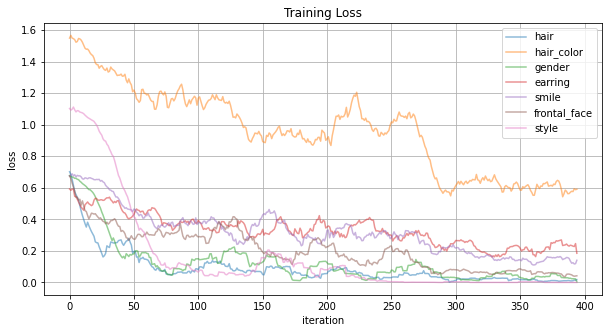

In [50]:
plot_training_loss()

In [51]:
# load best classifiers
for key in N_CLASSES:
    net.classifiers[key].load_state_dict(best_classifier[key])
torch.save(net.state_dict(), './best_model.pth')

In [57]:
@torch.no_grad()
def validate_full(net, verbose=True):
    net.eval()
    correct = {key: 0 for key in N_CLASSES}
    preds = {key: [] for key in N_CLASSES}
    gts = {key: [] for key in N_CLASSES}
    n_sample = len(val_loader) * BATCH_SIZE
    for i, (img, label) in enumerate(val_loader):
        img = img.cuda()
        output = net(img)
        pred = {key: output[key].argmax(dim=1).cpu() for key in N_CLASSES}
        correct = {key: correct[key] + (pred[key] == label[key]).sum().item()\
             for key in N_CLASSES}
        for key in N_CLASSES:
            preds[key].extend(pred[key].tolist())
            gts[key].extend(label[key].tolist())
    acc_per_task = {key: correct[key] / n_sample for key in N_CLASSES}
    if verbose:
        print('Eval:', end='')
        for key in N_CLASSES:
            print(' [{} {:.2f}]'.format(key, acc_per_task[key] * 100), end='\t')
        print()
    # plot confusion matrix for each task
    for key in N_CLASSES:
        plot_confusion_matrix(gts[key], preds[key], N_CLASSES[key], key)
    return acc_per_task

def plot_confusion_matrix(gts, preds, n_class, task_name):
    cm = confusion_matrix(gts, preds, n_class)
    gt_portion = np.sum(cm, axis=1) / np.sum(cm)
    pred_portion = np.sum(cm, axis=0) / np.sum(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(task_name)
    plt.colorbar()
    ytick_marks = [f'{i}({int(gt_portion[i]*100)}%)' for i in range(n_class)]
    xtick_marks = [f'{i}({int(pred_portion[i]*100)}%)' for i in range(n_class)]
    plt.yticks(np.arange(n_class), ytick_marks)
    plt.xticks(np.arange(n_class), xtick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./confusion_matrix_{}.png'.format(task_name))
    plt.close()

def confusion_matrix(gts, preds, n_class):
    cm = np.zeros((n_class, n_class))
    for gt, pred in zip(gts, preds):
        cm[gt][pred] += 1
    return cm

In [58]:
validate_full(net)

Eval: [hair 96.95]	 [hair_color 53.34]	 [gender 95.61]	 [earring 86.35]	 [smile 81.58]	 [frontal_face 88.84]	 [style 90.46]	


{'hair': 0.9694656488549618,
 'hair_color': 0.5333969465648855,
 'gender': 0.9561068702290076,
 'earring': 0.8635496183206107,
 'smile': 0.8158396946564885,
 'frontal_face': 0.8883587786259542,
 'style': 0.9045801526717557}